In [1]:
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import os
import csv
import shutil
import kaggle

In [2]:
kaggle.api.authenticate()

kaggle.api.dataset_download_files('samuelcortinhas/muffin-vs-chihuahua-image-classification', path='dataset', unzip=True)

In [3]:
def create_class_folder(source_folder_train, source_folder_test, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(source_folder_train):
        source_file = os.path.join(source_folder_train, filename)
        destination_file = os.path.join(destination_folder, filename)
        shutil.move(source_file, destination_file)

    for filename in os.listdir(source_folder_test):
        source_file = os.path.join(source_folder_test, filename)
        destination_file = os.path.join(destination_folder, filename)
        shutil.move(source_file, destination_file)


In [4]:
dataset_folder = "dataset"

source_folder_train = os.path.join(dataset_folder, "train", "chihuahua")
source_folder_test = os.path.join(dataset_folder, "test", "chihuahua")
destination_folder = os.path.join(dataset_folder, "chihuahua_all")

create_class_folder(source_folder_train, source_folder_test, destination_folder)

source_folder_train = os.path.join(dataset_folder, "train", "muffin")
source_folder_test = os.path.join(dataset_folder, "test", "muffin")
destination_folder = os.path.join(dataset_folder, "muffin_all")

create_class_folder(source_folder_train, source_folder_test, destination_folder)

shutil.rmtree(os.path.join(dataset_folder, "train"))
shutil.rmtree(os.path.join(dataset_folder, "test"))

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
else:
    print("Nessuna GPU abilitata. TensorFlow sta utilizzando la CPU.")


In [6]:
def load_dataset(dataset_dir):
        data = []
        labels = []
        class_dirs = os.listdir(dataset_dir)
        class_dict = {cls: i for i, cls in enumerate(class_dirs)}

        for cls in class_dirs:
            class_dir = os.path.join(dataset_dir, cls)
            class_label = class_dict[cls]

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                image = Image.open(image_path).convert("L")
                image = image.resize((64, 64)) 
                image = np.array(image) 
                data.append(image)
                labels.append(class_label)

        data = np.array(data)
        data = data/255
        labels = np.array(labels)

        return data, labels

In [7]:
def model1(lr):
    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [8]:
def model2(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),  
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [9]:
def model3(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [10]:
def model4(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [11]:
def plot_risks_matrix(model, risks, epochs):
    
    risks_matrix = np.array(risks).reshape(len(learning_rates), len(batch_size))
    epochs_matrix = np.array(epochs).reshape(len(learning_rates), len(batch_size))

    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(learning_rates)))
    ax.set_yticks(np.arange(len(batch_size)))
    ax.set_xticklabels(learning_rates)
    ax.set_yticklabels(batch_size)

    plt.xlabel("Learning Rate")
    plt.ylabel("Batch Size")
    plt.title(f"{model.__name__} - Risks for Different Learning Rates and Batch Sizes")

    for i in range(len(learning_rates)):
        for j in range(len(batch_size)):
            text = ax.text(j, i, f"{risks_matrix[i, j]:.4f}\n{epochs_matrix[i, j]}", ha="center", va="center", color="w")

    im = ax.imshow(risks_matrix, cmap="coolwarm", aspect='auto')
    
    im.set_clim(0, 0.5)

    plt.colorbar(im)
    
    plt.savefig(f'graph/{model.__name__}_risks.png')
    plt.show()

In [12]:
def cross_val(model, X, Y, batch_size, learning_rate, patience):
    
    print(f"{model.__name__} batch_size: {batch_size} learning_rate: {learning_rate}")
    
    zero_one_losses = []
    
    epochs = []
    train_data = []
    val_data = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    splits = skf.split(X, Y)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        
    with tf.device('/gpu:0'):
        for fold, (train_index, val_index) in enumerate(splits):

            train_data = X[train_index]
            train_labels = Y[train_index]
            val_data = X[val_index]
            val_labels = Y[val_index]

            print(f"Fold {fold+1}/5")
            actual_model = model(learning_rate)
            history = actual_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=[early_stopping], batch_size = batch_size, epochs = 100, verbose=0)
            
            best_epoch = np.argmin(history.history["val_loss"])
                        
            zero_one_loss = 1 - history.history["val_accuracy"][best_epoch]
            
            zero_one_losses.append(zero_one_loss)
        
            epochs.append(best_epoch + 1)
            print(f"loss: {history.history['loss'][best_epoch]} val_loss: {history.history['val_loss'][best_epoch]} zo_loss: {zero_one_loss} epoch: {best_epoch+1}")
    
    risk = np.mean(zero_one_losses)
    epochs_mean = np.mean(epochs)
    print(f"risk estimate: {risk}")
    
    return risk, epochs_mean

In [13]:
def hyperparameter_test_cross_validation(model, X, Y): 
    risks = []
    mean_epochs = []
    
    for b in batch_size:
        for lr in learning_rates:
            risk, mean_epoch = cross_val(model, X, Y, b, lr, patience)
            risks.append(risk)
            mean_epochs.append(mean_epoch) 
            
    
    with open(f'result/{model.__name__}_risks.pkl', 'wb') as file:
        pickle.dump(risks, file)
    
    with open(f'result/{model.__name__}_epochs.pkl', 'wb') as file:
        pickle.dump(mean_epochs , file)
        
    return risks, mean_epochs

In [14]:
def write_csv(models, risks, epochs):
    if os.path.exists("result/result.csv"):
        os.remove("result/result.csv")
   
    with open("result/result.csv", mode="w", newline="") as csv_file:
        fieldnames = ["Model", "Learning Rate", "Batch Size", "Epochs Mean", "Risk"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()

        for i in range(len(batch_size)):
            for j in range(len(learning_rates)):
                for m in range(len(models)):
                    model_name = models[m].__name__
                    epochs_mean = epochs[m][i * len(batch_size) + j] 
                    lr = learning_rates[j]
                    bs = batch_size[i]
                    risk = risks[m][i * len(batch_size) + j]
                    writer.writerow({"Model": model_name, "Learning Rate": lr, "Batch Size": bs, "Epochs Mean": epochs_mean, "Risk": risk})


In [15]:
X, Y = load_dataset("data/dataset")
if os.path.exists("result/result.txt"):
    os.remove("result/result.txt")

In [16]:
learning_rates = [0.01, 0.001, 0.0001]
batch_size = [16, 64, 256]
patience = 5

In [17]:
model1_risks, model1_epochs = hyperparameter_test_cross_validation(model1, X, Y)

model1 batch_size: 16 learning_rate: 0.01
Fold 1/5
loss: 0.6902312636375427 val_loss: 0.6898570656776428 zo_loss: 0.45945948362350464 epoch: 11
Fold 2/5
loss: 0.6901043653488159 val_loss: 0.6888107061386108 zo_loss: 0.45945948362350464 epoch: 3
Fold 3/5
loss: 0.6897627711296082 val_loss: 0.6787546873092651 zo_loss: 0.4590025544166565 epoch: 7
Fold 4/5
loss: 0.6902332305908203 val_loss: 0.6897836327552795 zo_loss: 0.4590025544166565 epoch: 14
Fold 5/5
loss: 2.563457489013672 val_loss: 0.6854737401008606 zo_loss: 0.4598478674888611 epoch: 1
risk estimate: 0.45935438871383666
model1 batch_size: 16 learning_rate: 0.001
Fold 1/5
loss: 0.6770344376564026 val_loss: 0.6533017158508301 zo_loss: 0.4197635054588318 epoch: 2
Fold 2/5
loss: 0.6611119508743286 val_loss: 0.6708062887191772 zo_loss: 0.4771959185600281 epoch: 6
Fold 3/5
loss: 0.5528298616409302 val_loss: 0.6104657649993896 zo_loss: 0.3448858857154846 epoch: 20
Fold 4/5
loss: 0.609573483467102 val_loss: 0.6032472252845764 zo_loss: 0.324

In [21]:
model2_risks, model2_epochs = hyperparameter_test_cross_validation(model2, X, Y)

model2 batch_size: 16 learning_rate: 0.01
Fold 1/5
loss: 0.6902608871459961 val_loss: 0.6898624300956726 zo_loss: 0.45945948362350464 epoch: 18
Fold 2/5
loss: 0.6904793381690979 val_loss: 0.689857006072998 zo_loss: 0.45945948362350464 epoch: 10
Fold 3/5
loss: 0.6902800798416138 val_loss: 0.689785897731781 zo_loss: 0.4590025544166565 epoch: 8
Fold 4/5
loss: 0.4732869863510132 val_loss: 0.5228877663612366 zo_loss: 0.24767541885375977 epoch: 5
Fold 5/5
loss: 0.6906813979148865 val_loss: 0.6899460554122925 zo_loss: 0.4598478674888611 epoch: 5
risk estimate: 0.4170889616012573
model2 batch_size: 16 learning_rate: 0.001
Fold 1/5
loss: 0.20453733205795288 val_loss: 0.3578084111213684 zo_loss: 0.14780408143997192 epoch: 6
Fold 2/5
loss: 0.26474761962890625 val_loss: 0.3757184147834778 zo_loss: 0.16554051637649536 epoch: 5
Fold 3/5
loss: 0.2696812152862549 val_loss: 0.34549209475517273 zo_loss: 0.14877432584762573 epoch: 5
Fold 4/5
loss: 0.3158836364746094 val_loss: 0.35549017786979675 zo_loss:

In [26]:
model3_risks, model3_epochs = hyperparameter_test_cross_validation(model3, X, Y)

model3 batch_size: 16 learning_rate: 0.01
Fold 1/5
loss: 0.40818920731544495 val_loss: 0.5019606351852417 zo_loss: 0.23564189672470093 epoch: 6
Fold 2/5
loss: 0.6901347637176514 val_loss: 0.6898605227470398 zo_loss: 0.45945948362350464 epoch: 10
Fold 3/5
loss: 0.6901631355285645 val_loss: 0.6897956132888794 zo_loss: 0.4590025544166565 epoch: 8
Fold 4/5
loss: 0.5187097191810608 val_loss: 0.5347157716751099 zo_loss: 0.26204562187194824 epoch: 7
Fold 5/5
loss: 0.690398097038269 val_loss: 0.6899195313453674 zo_loss: 0.4598478674888611 epoch: 5
risk estimate: 0.37519948482513427
model3 batch_size: 16 learning_rate: 0.001
Fold 1/5
loss: 0.28558000922203064 val_loss: 0.36761394143104553 zo_loss: 0.16047298908233643 epoch: 5
Fold 2/5
loss: 0.35247957706451416 val_loss: 0.4034186005592346 zo_loss: 0.18581080436706543 epoch: 3
Fold 3/5
loss: 0.2338678240776062 val_loss: 0.3297240138053894 zo_loss: 0.13524937629699707 epoch: 5
Fold 4/5
loss: 0.22630827128887177 val_loss: 0.35813239216804504 zo_lo

In [27]:
model4_risks, model4_epochs = hyperparameter_test_cross_validation(model4, X, Y)

model4 batch_size: 16 learning_rate: 0.01
Fold 1/5
loss: 0.690229594707489 val_loss: 0.6898574829101562 zo_loss: 0.45945948362350464 epoch: 12
Fold 2/5
loss: 0.6902148127555847 val_loss: 0.6898600459098816 zo_loss: 0.45945948362350464 epoch: 6
Fold 3/5
loss: 0.6904883980751038 val_loss: 0.6897834539413452 zo_loss: 0.4590025544166565 epoch: 5
Fold 4/5
loss: 0.6903649568557739 val_loss: 0.6897860169410706 zo_loss: 0.4590025544166565 epoch: 5
Fold 5/5
loss: 0.7527238130569458 val_loss: 0.6899203658103943 zo_loss: 0.4598478674888611 epoch: 1
risk estimate: 0.45935438871383666
model4 batch_size: 16 learning_rate: 0.001
Fold 1/5
loss: 0.38153356313705444 val_loss: 0.40350523591041565 zo_loss: 0.17145270109176636 epoch: 5
Fold 2/5
loss: 0.35739919543266296 val_loss: 0.37929436564445496 zo_loss: 0.1689189076423645 epoch: 3
Fold 3/5
loss: 0.31128519773483276 val_loss: 0.3761567771434784 zo_loss: 0.16145390272140503 epoch: 4
Fold 4/5
loss: 0.3151564598083496 val_loss: 0.37915852665901184 zo_loss

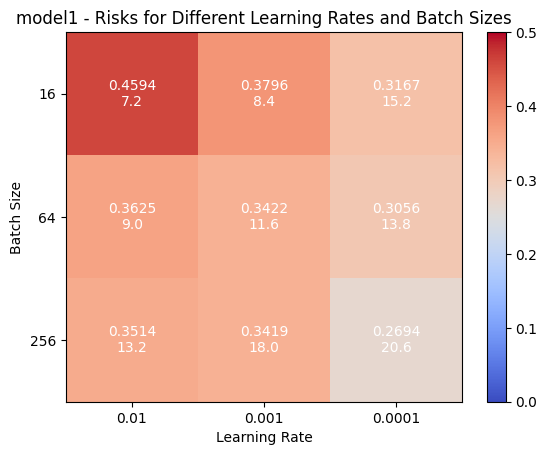

In [18]:
plot_risks_matrix(model1, model1_risks, model1_epochs)

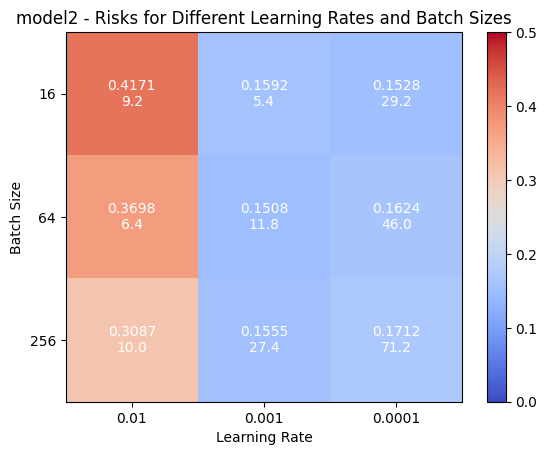

In [35]:
plot_risks_matrix(model2, model2_risks, model2_epochs)

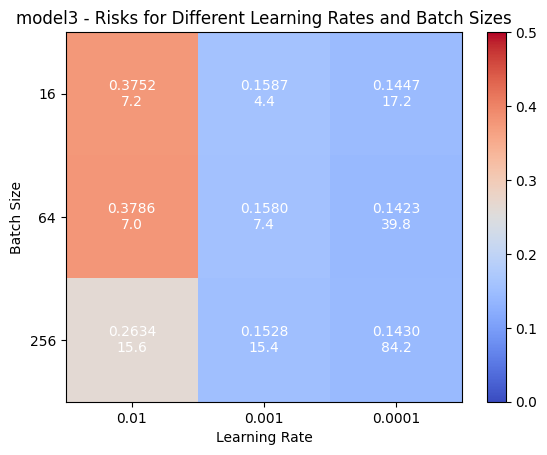

In [36]:
plot_risks_matrix(model3, model3_risks, model3_epochs)


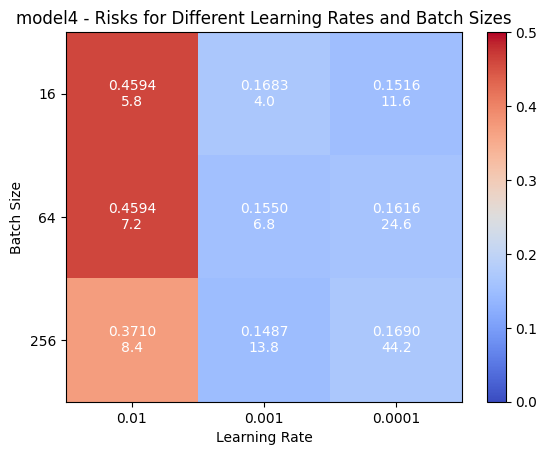

In [37]:
plot_risks_matrix(model4, model4_risks, model4_epochs)

In [38]:
models = [model1, model2, model3, model4]
risks = [model1_risks, model2_risks, model3_risks, model4_risks]
epochs = [model1_epochs, model2_epochs, model3_epochs, model4_epochs]

write_csv(models, risks, epochs)